# Assignment: Zero-Crossing Rate¶
### Jan Robert Eljasiak 909837
### Master’s Degree in Data Science (A.Y. 2024/2025)

In [83]:
import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile as wav
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
# Classification tools
from sklearn.svm import SVC

## Data loader¶

In [84]:
# Placecholder for feature extractor
def identity(input):
    return input


# Data loader
def load_data(feature_extractor=identity, normalize=False):
    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps) / (X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps) / (X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# Zero Crossing Rate

The Zero Crossing Rate (ZCR) measures the rate at which a signal changes its sign (crosses the zero axis). It is computed using the formula:
$$ ZCR = \frac{1}{2} \sum_{i=1}^{n} | \text{sign}(x_{i}) - \text{sign}(x_{i-1}) |$$

where:
-$x_i$ represents the amplitude of a discrete-time signal at index.
-sign(x) is the sign function, returning +1 for positive values, -1 for negative values, and 0 for zero.


For each sample $i = 1, \ldots, n$

$$\frac{1}{2} | \text{sign}(x_{i}) - \text{sign}(x_{i-1}) | = 
    \begin{cases}
      1 \text{ if the sign change (positive to negative or vice versa)} \\
      0 \text{ otherwise}
    \end{cases}$$
    
Therefore, ZCR represents the number of times the signal transitions between positive and negative.

In [85]:
def zcr(input):
    """
    Computes the Zero-Crossing Rate (ZCR) for an audio signal.
    :param input: 1D numpy array representing audio signal.
    :return: ZCR value as a numpy array.
    """
    sign_changes = [np.abs(np.sign(input[i]) - np.sign(input[i - 1])) for i in range(1, len(input))]
    return np.array([np.sum(sign_changes) // 2])


# Test ZCR function
zcr([1, -2, 3, 4, 5, -1])

array([3])

In [86]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr)
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.53      0.26      0.35        34
           1       0.90      0.19      0.32        47
           2       0.33      0.29      0.31        17
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.07      0.14      0.10         7
           6       0.64      0.75      0.69        12
           7       0.00      0.00      0.00         3
           8       0.12      0.20      0.15        10
           9       0.36      0.25      0.29        20

    accuracy                           0.27       150
   macro avg       0.30      0.21      0.22       150
weighted avg       0.55      0.27      0.32       150


C:\Users\eljas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eljas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eljas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [87]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

Confusion matrix:
[[ 9  5  1  0  0  2  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  1]
 [ 3  2  5  0  0  1  0  0  2  2]
 [ 2 14  1  0  0  0  0  0  0  2]
 [ 3  5  0  0  0  0  0  0  0  3]
 [ 3  2  3  0  0  1  1  2  0  2]
 [ 0  2  0  0  0  0  9  1  1  1]
 [ 4  2  2  0  0  2  2  0  4  3]
 [ 4  5  5  0  0  0  0  0  2  1]
 [ 6  1  0  0  0  1  0  0  1  5]]


Text(0, 0.5, 'Actual')

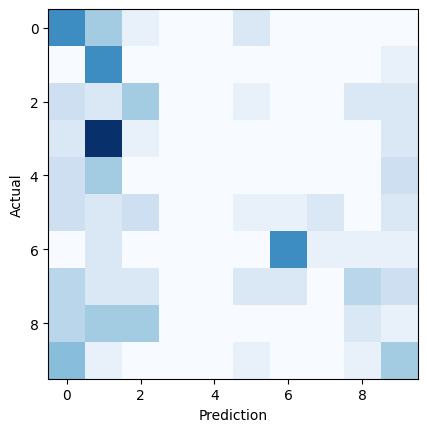

In [88]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [89]:
# Implementation of the functions from the laboratories

def energy(input):
    return np.sum((input * 1.0) ** 2, keepdims=True)


def duration(input):
    return np.array(input.shape)


def combo2(input):
    return np.concatenate((energy(input), duration(input), zcr(input)))

## Classification Using Combined Features

In [90]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo2, normalize=True)
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))

Training completed in 2.077s
Best parameters combination:
 C: 100
 gamma: 0.5


In [91]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.44      0.80      0.57        10
           2       0.54      0.47      0.50        15
           3       0.62      0.42      0.50        19
           4       0.50      0.45      0.48        11
           5       0.30      0.43      0.35        14
           6       0.81      0.93      0.87        14
           7       0.56      0.26      0.36        19
           8       0.44      0.47      0.46        17
           9       0.58      0.79      0.67        14

    accuracy                           0.55       150
   macro avg       0.56      0.57      0.55       150
weighted avg       0.57      0.55      0.55       150


Confusion matrix:


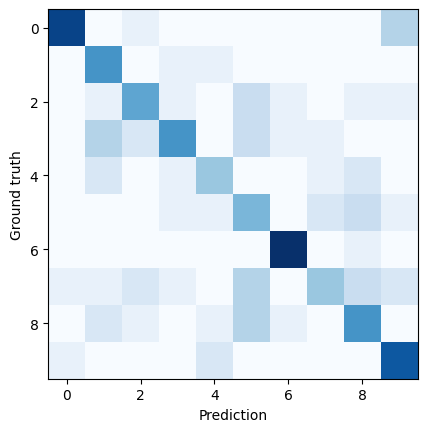

In [92]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');